In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 200
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 200
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/800-200'

In [6]:
os.chdir('../../Datasets/Energies')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Energies'

In [7]:
!ls

D_-_spain_biomass.csv	       D-spain_other.csv
D_-_spain_fossilbrowncoal.csv  D-spain_other_ren.csv
D_-_spain_fossilgas.csv        D-spain_reservoir.csv
D_-_spain_fossilhardcoal.csv   D-spain_river.csv
D_-_spain_fossiloil.csv        D-spain_solar.csv
D-spain_hydroconsump.csv       D-spain_waste.csv
D-spain_nuclear.csv	       D-spain_wind_onshore.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-spain_reservoir
Initial log joint probability = -30.4865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1015.89    0.00239004       61.5479           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1016.52    0.00593487       212.867    7.03e-05       0.001      175  LS failed, Hessian reset 
     178       1016.99    1.4351e-08       73.4863      0.1466      0.4395      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
D_-_spain_fossilhardcoal
Initial log joint probability = -29.3926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       832.733    0.00047949       69.3717      0.9714       0.272      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       832.795   0.00

Initial log joint probability = -8.17672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1871.27   0.000646992       75.4466       0.632       0.632      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       1871.41   0.000679661       143.549   7.151e-06       0.001      170  LS failed, Hessian reset 
     167       1871.71     0.0013135       303.679    1.06e-05       0.001      298  LS failed, Hessian reset 
     199       1871.82   9.01406e-06       72.7492      0.2813      0.2813      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       1871.98   0.000119308       93.7708   1.154e-06       0.001      498  LS failed, Hessian reset 
     299       1871.99   2.32173e-06       83.3314      0.2375      0.7809      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

In [10]:
df

[            ds        y
 0   2015-01-01  52005.0
 1   2015-01-02  89159.0
 2   2015-01-03  95266.0
 3   2015-01-04  77792.0
 4   2015-01-05  43206.0
 ..         ...      ...
 995 2017-09-22  33498.0
 996 2017-09-23  31385.0
 997 2017-09-24  25068.0
 998 2017-09-25  28449.0
 999 2017-09-26  30484.0
 
 [1000 rows x 2 columns],
             ds         y
 0   2015-01-01  101917.0
 1   2015-01-02   29688.0
 2   2015-01-03   32262.0
 3   2015-01-04   53879.0
 4   2015-01-05   44880.0
 ..         ...       ...
 995 2017-09-22   97151.0
 996 2017-09-23   82386.0
 997 2017-09-24   83816.0
 998 2017-09-25  106490.0
 999 2017-09-26  122429.0
 
 [1000 rows x 2 columns],
             ds        y
 0   2015-01-01   6178.0
 1   2015-01-02      0.0
 2   2015-01-03      0.0
 3   2015-01-04      0.0
 4   2015-01-05    430.0
 ..         ...      ...
 995 2017-09-22  19553.0
 996 2017-09-23  15968.0
 997 2017-09-24  16457.0
 998 2017-09-25  20820.0
 999 2017-09-26  21409.0
 
 [1000 rows x 2 columns],
    

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-spain_reservoir,Naive Method,0.10158919196564554,0.019137167159432835,0.13833715032279953
1,D_-_spain_fossilhardcoal,Naive Method,0.20519760114653593,0.05968357538129767,0.24430222140066118
2,D_-_spain_fossilbrowncoal,Naive Method,0.40688327213730674,0.24046404788825892,0.490371336731929
3,D-spain_river,Naive Method,0.24231587824271142,0.0922443271782931,0.3037175121363487
4,D_-_spain_fossilgas,Naive Method,0.3424582510584094,0.1496546228522014,0.3868521976830446
5,D-spain_wind_onshore,Naive Method,0.15940901002957955,0.04882851923656736,0.22097176117451606
6,D-spain_solar,Naive Method,0.18898532372231963,0.052935065660681756,0.230076217068783
7,D-spain_other,Naive Method,0.13274547187797903,0.05103819198637589,0.22591633846708806
8,D-spain_hydroconsump,Naive Method,0.10280884978948576,0.030974090512445738,0.17599457523584566
9,D-spain_other_ren,Naive Method,0.13822663723325967,0.029156101557165814,0.1707515784909932


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-spain_reservoir,Prophet Method,0.1600721863986087,0.03734922199971948,0.19325946807263927
1,D_-_spain_fossilhardcoal,Prophet Method,0.2586671529273619,0.08830900387889574,0.2971683090083728
2,D_-_spain_fossilbrowncoal,Prophet Method,0.30180441916176226,0.14184745292911302,0.3766264102915687
3,D-spain_river,Prophet Method,0.12023218040950719,0.02983202649021941,0.1727195023447538
4,D_-_spain_fossilgas,Prophet Method,0.16013262061444195,0.03938265807504563,0.1984506439270118
5,D-spain_wind_onshore,Prophet Method,0.14093326555083405,0.03165108986797315,0.177907531791021
6,D-spain_solar,Prophet Method,0.18515119221924625,0.04580139244678076,0.21401259880385726
7,D-spain_other,Prophet Method,0.20864681879485297,0.05266719591305554,0.2294933461193495
8,D-spain_hydroconsump,Prophet Method,0.0977246805124447,0.023335522750444353,0.15275968954683153
9,D-spain_other_ren,Prophet Method,0.12597670477959644,0.02401082864800476,0.15495427921811247


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_200/prophet_results_energies.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_200/naive_results_energies.csv', index = False)

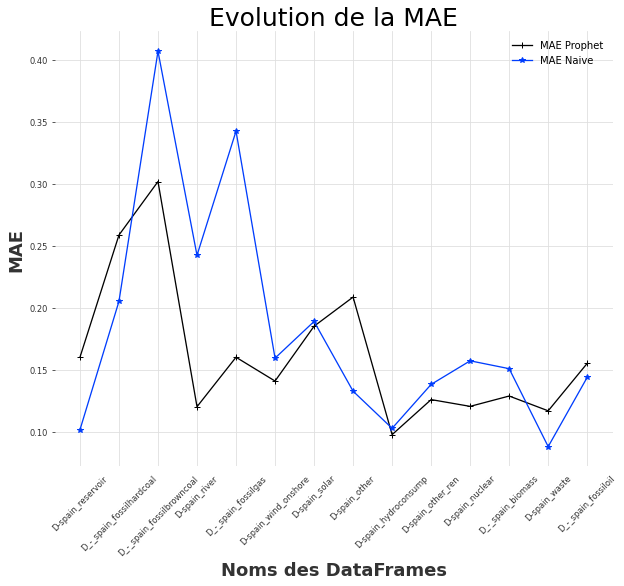

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

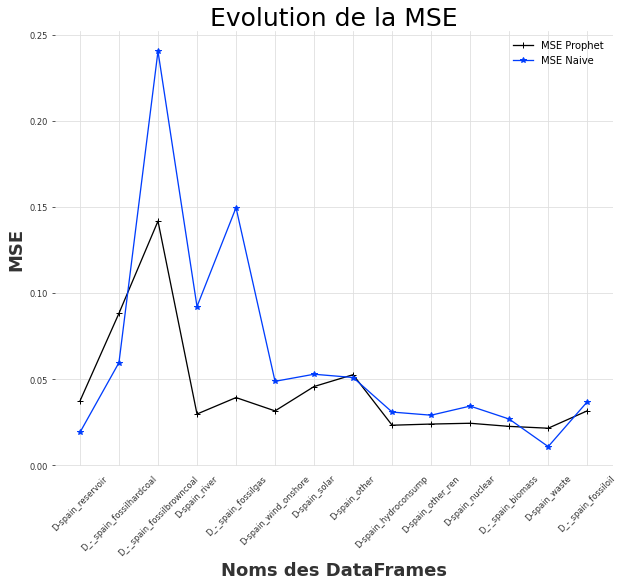

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

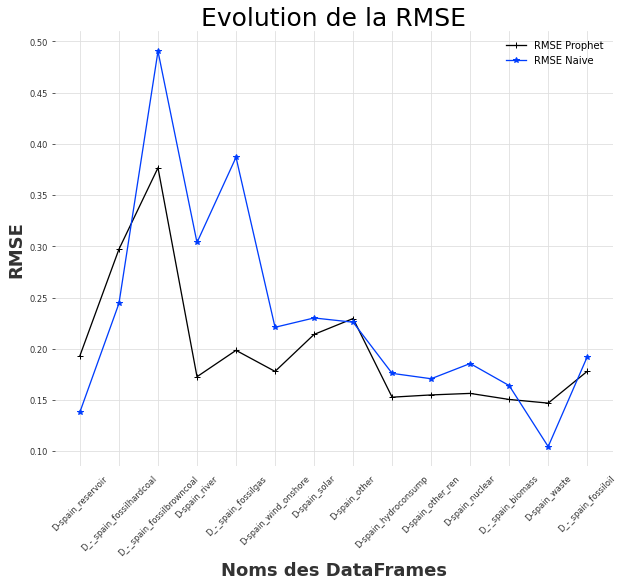

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

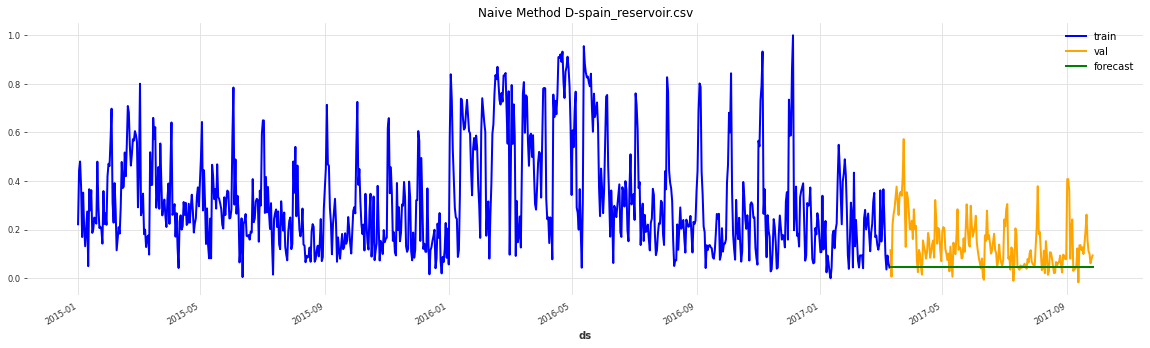

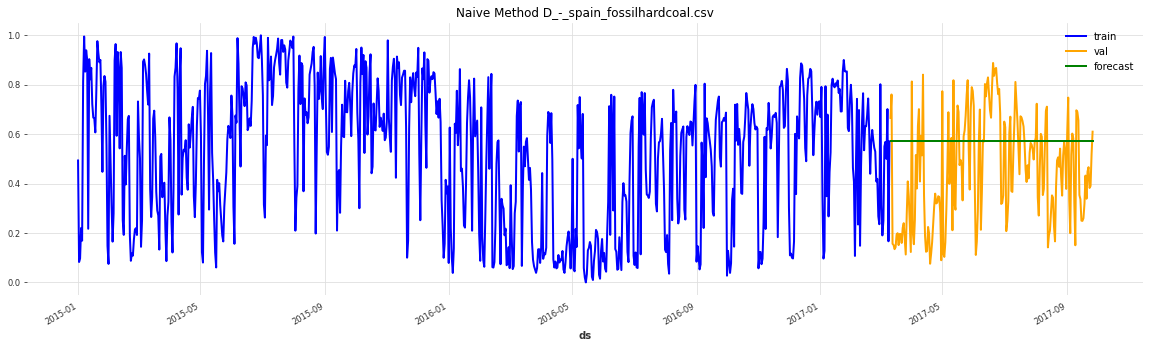

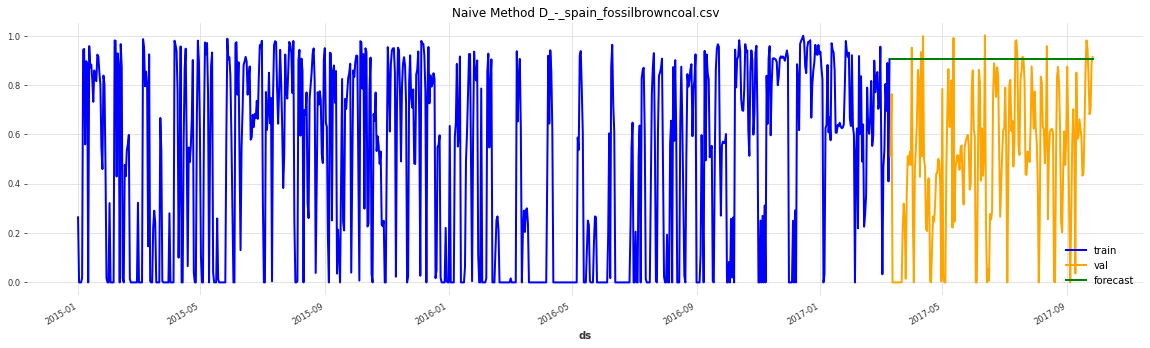

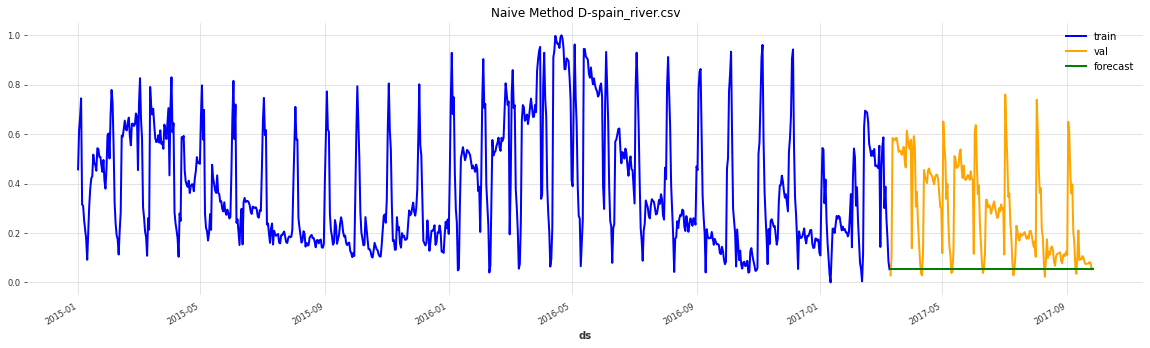

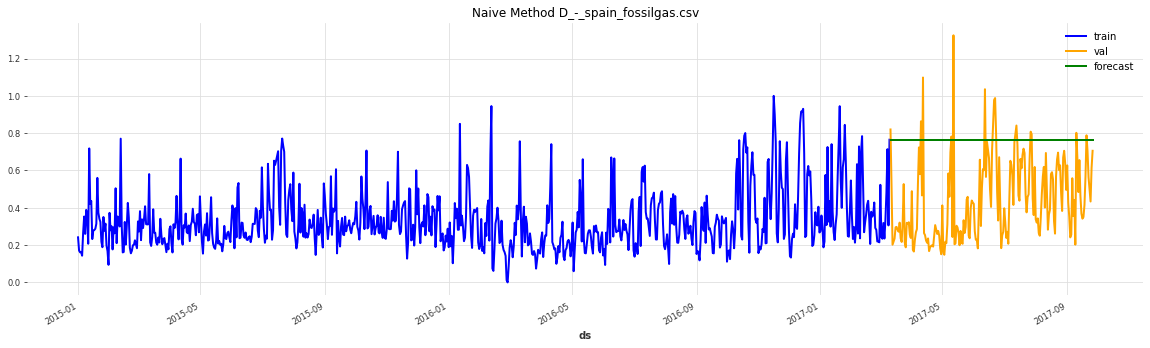

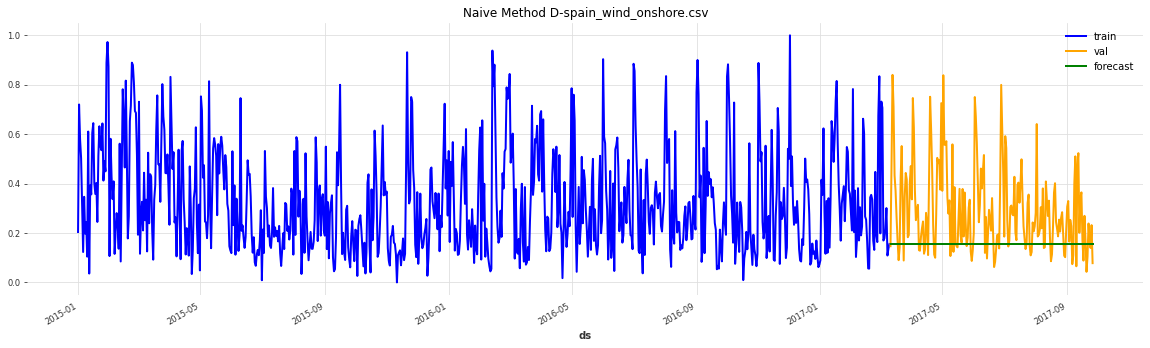

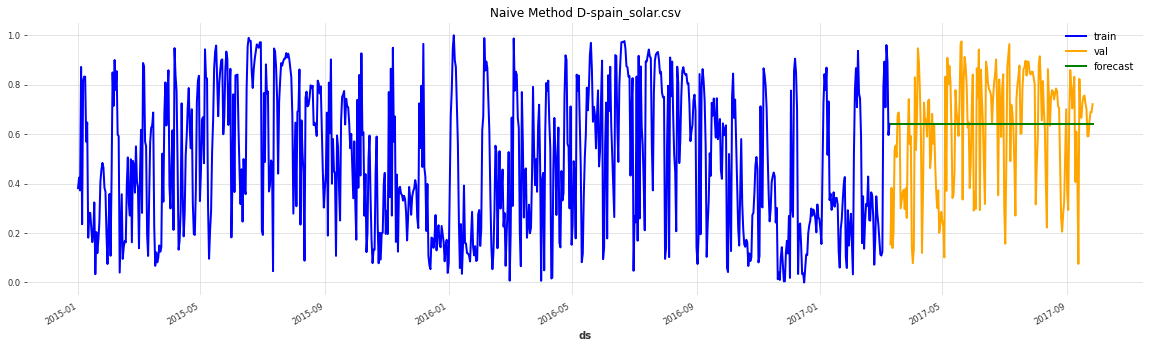

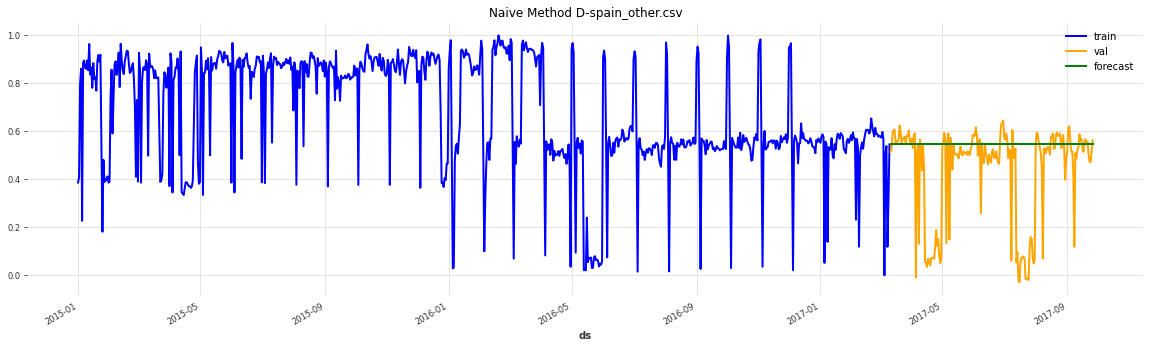

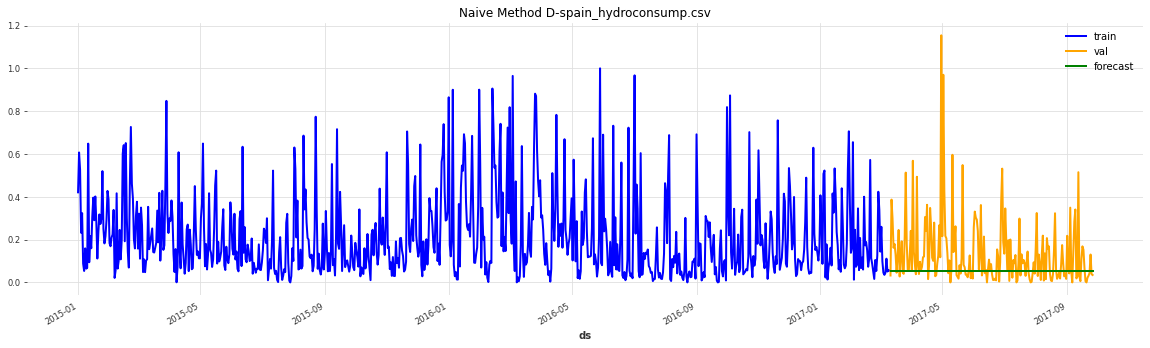

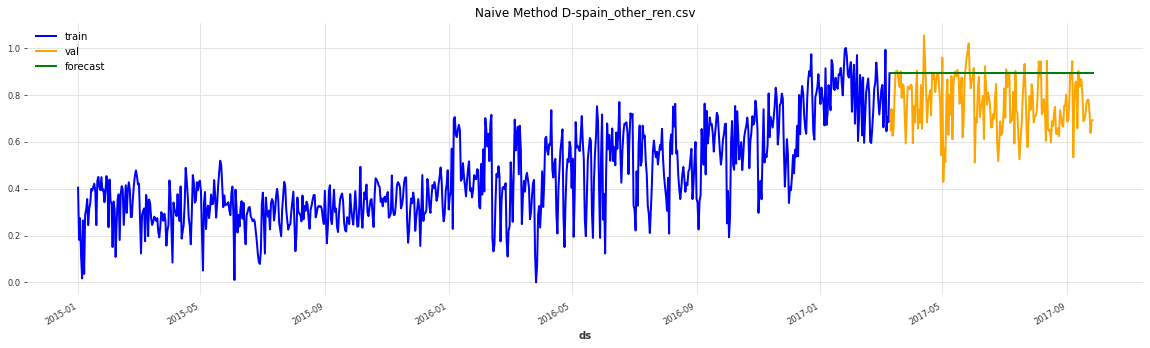

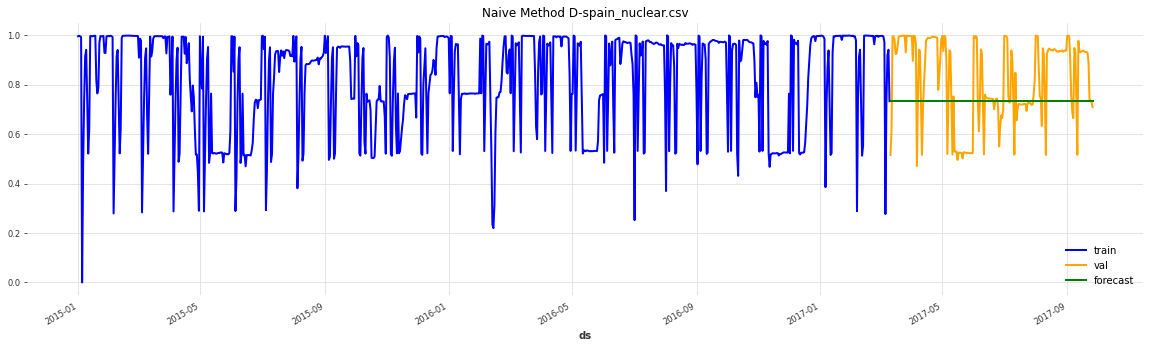

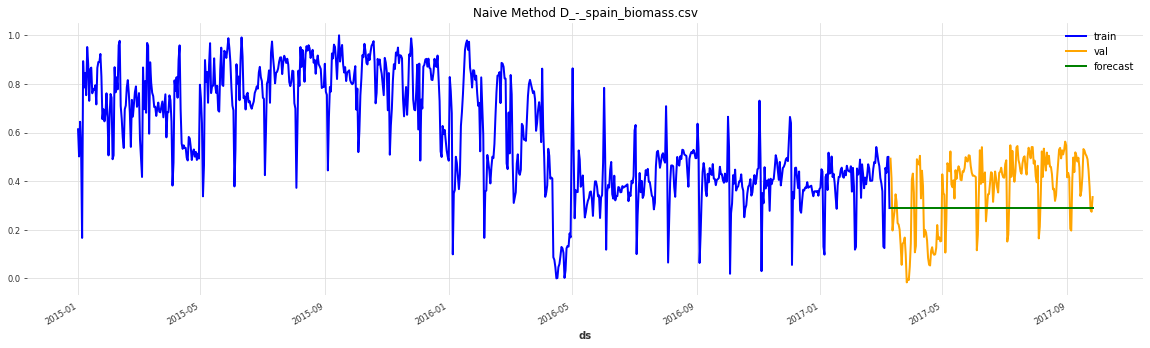

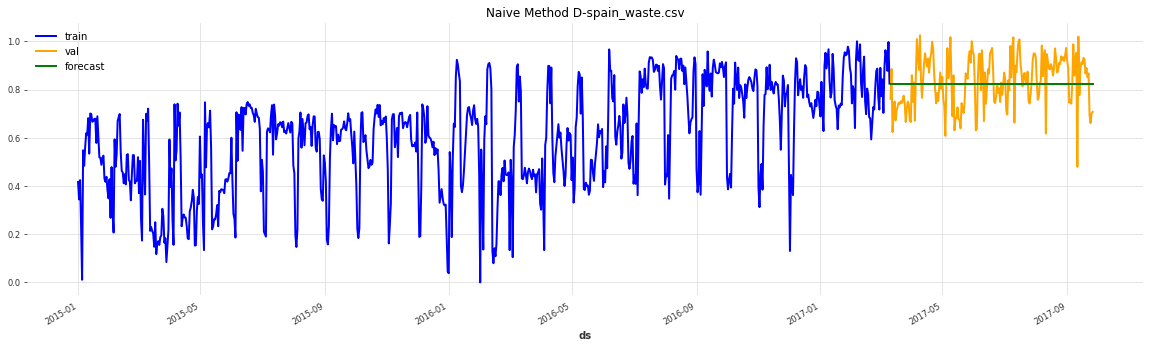

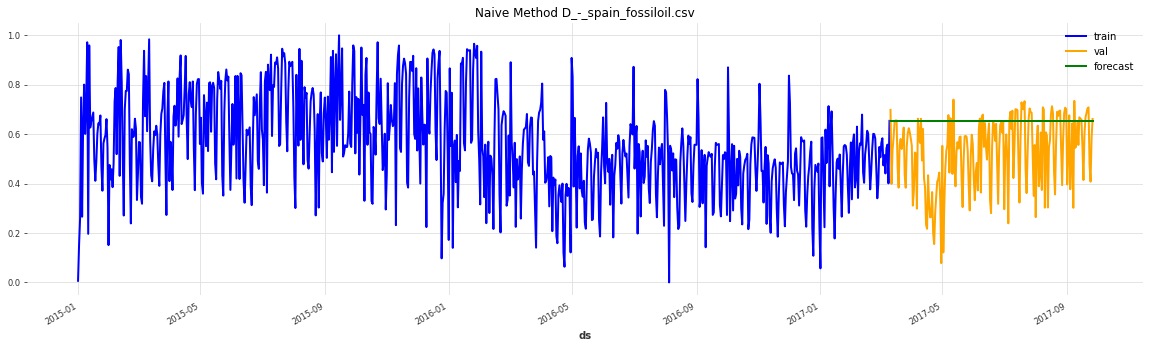

In [18]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

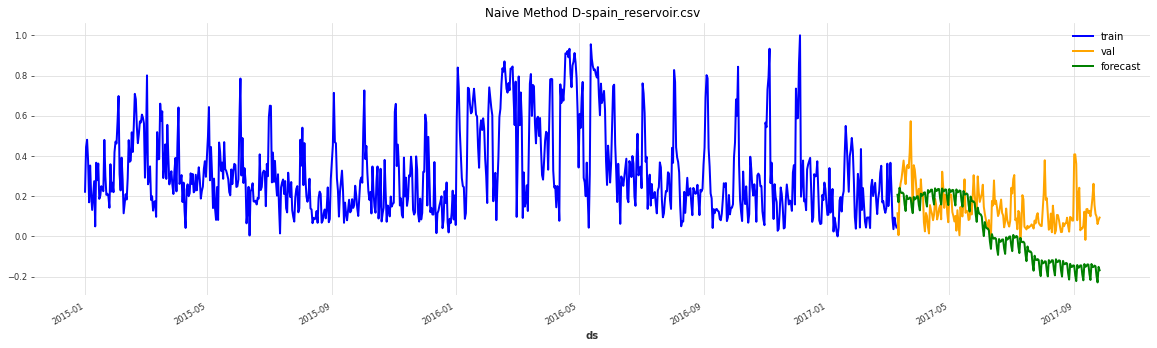

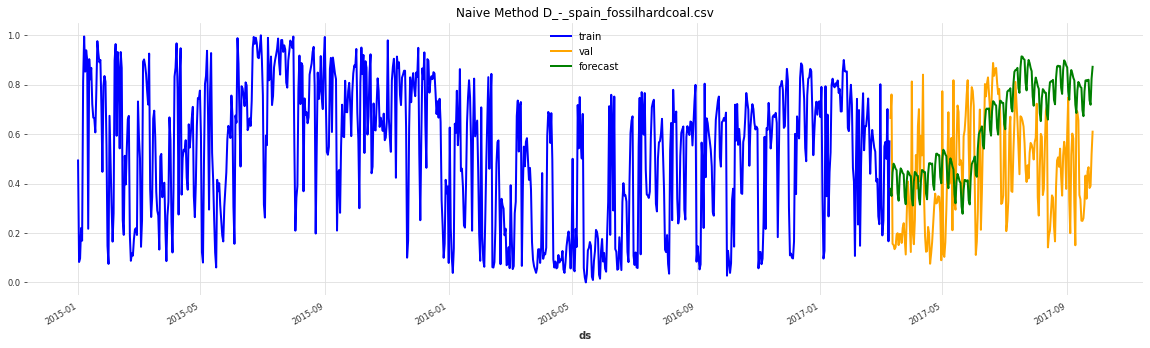

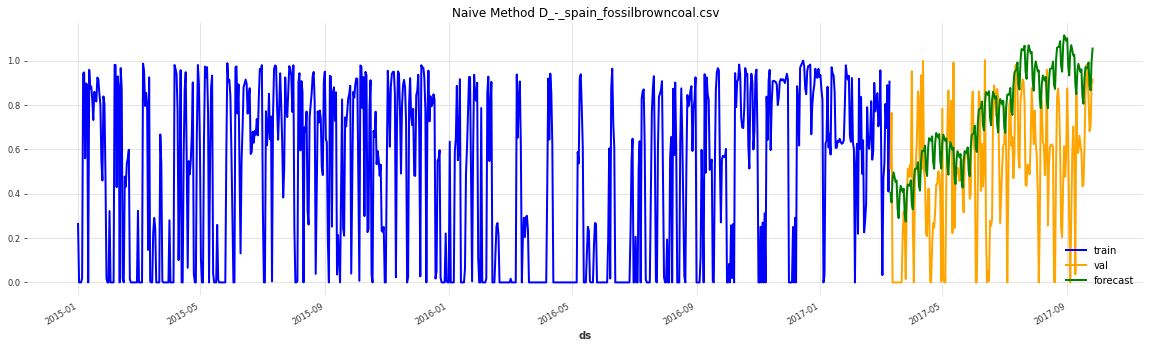

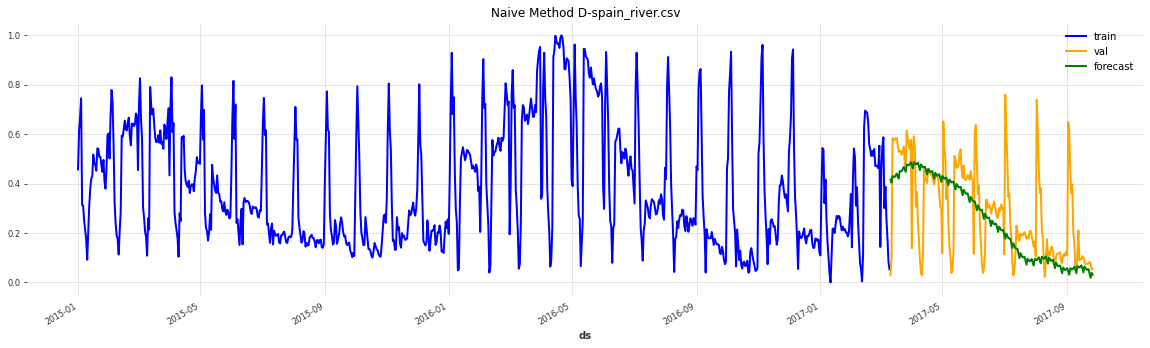

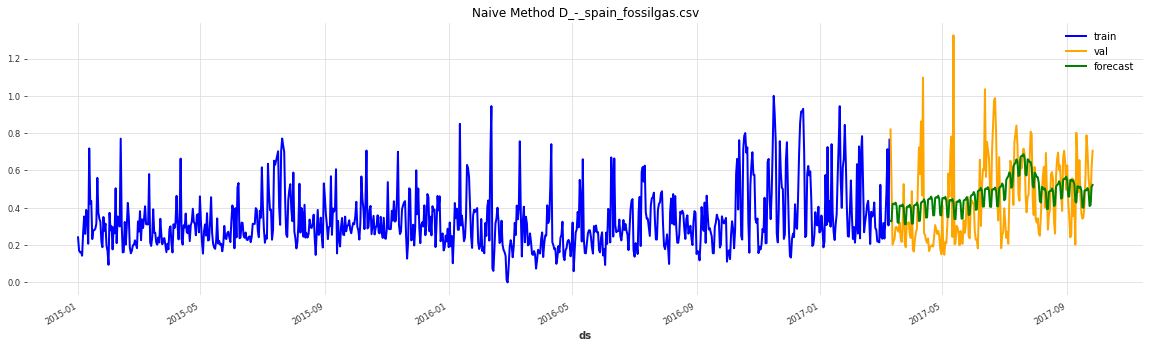

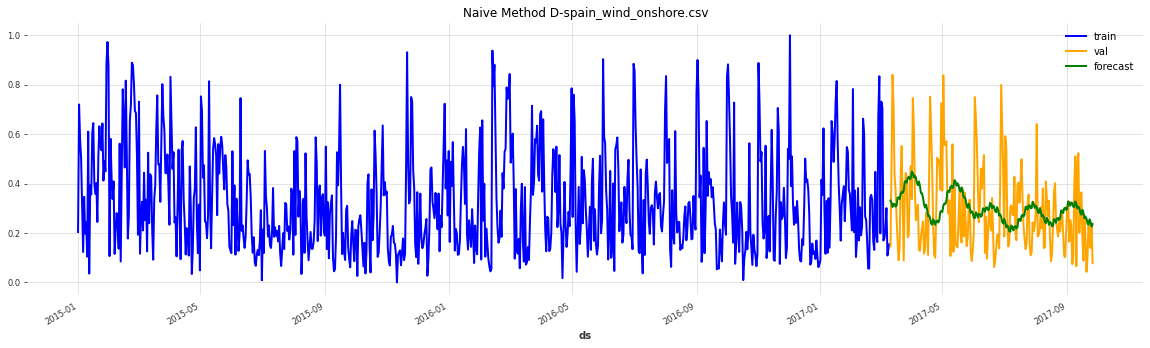

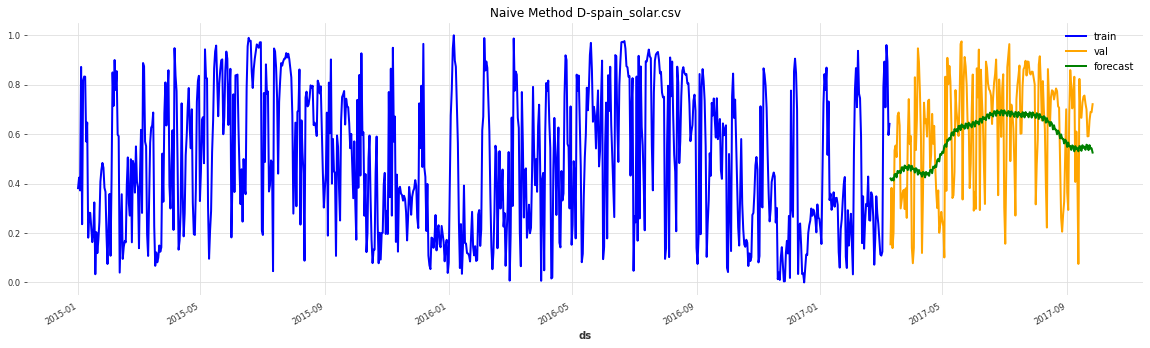

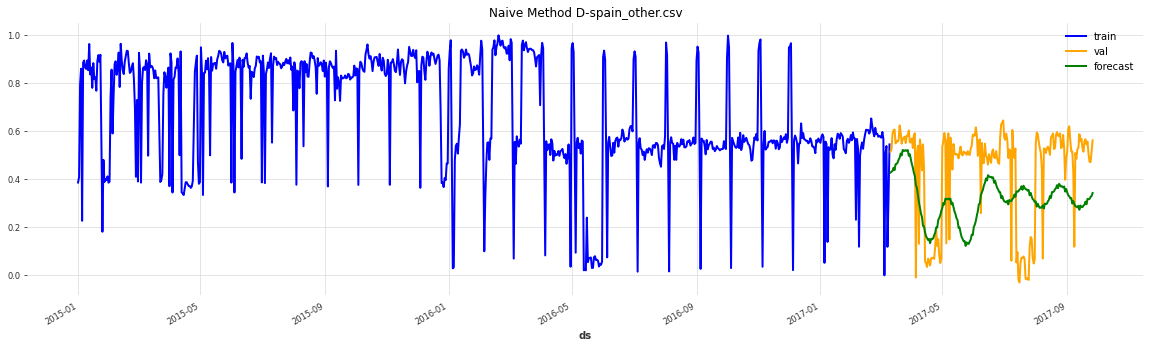

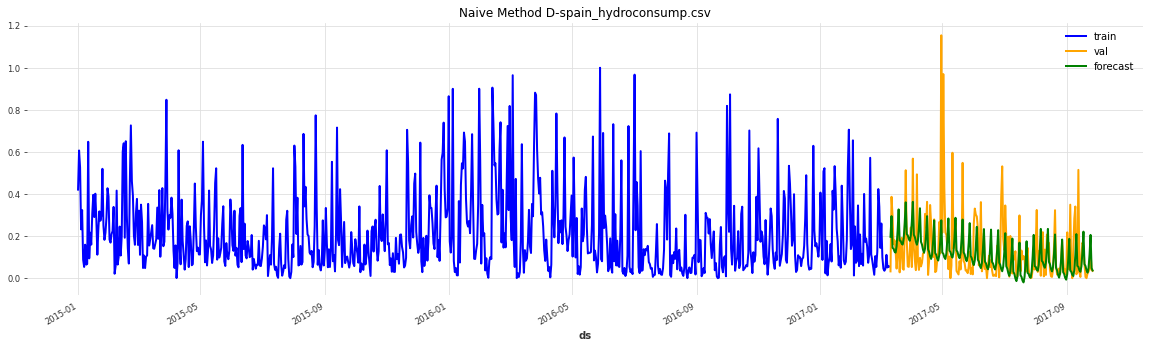

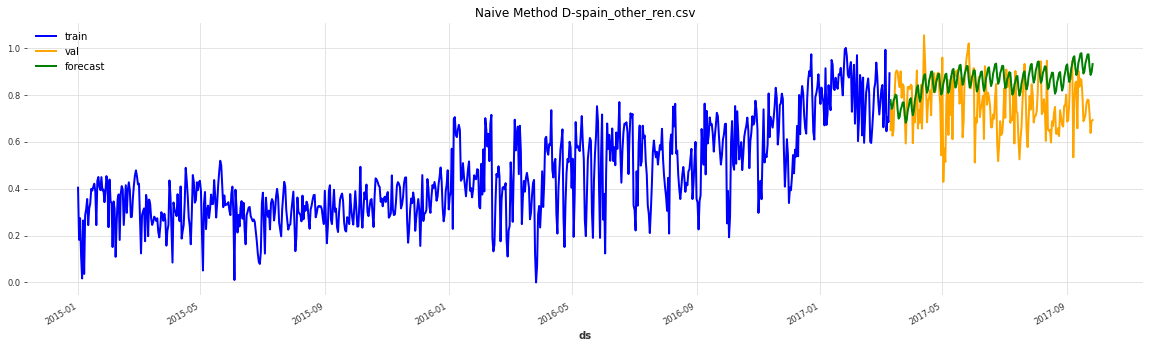

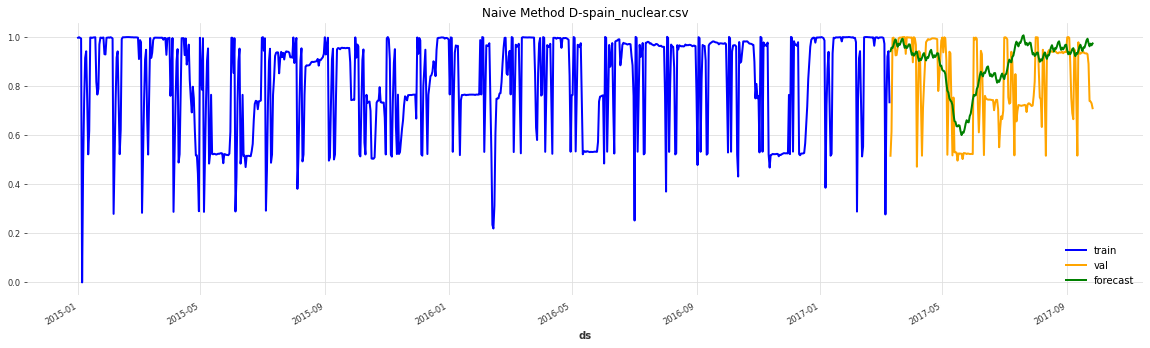

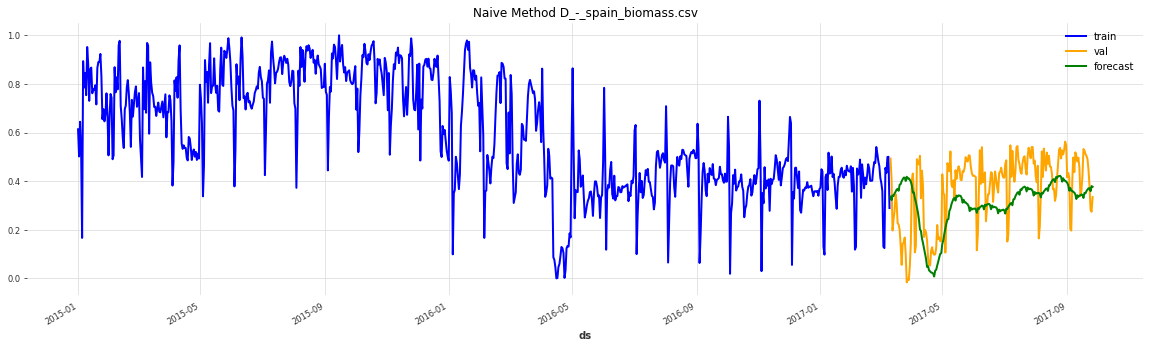

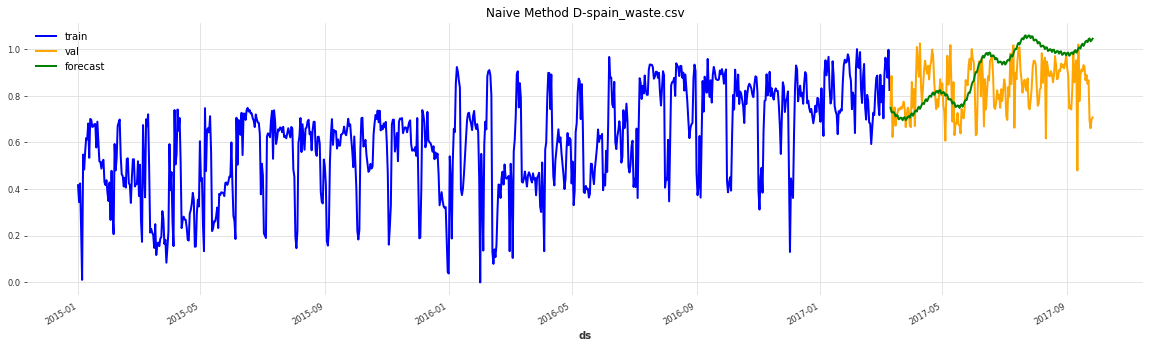

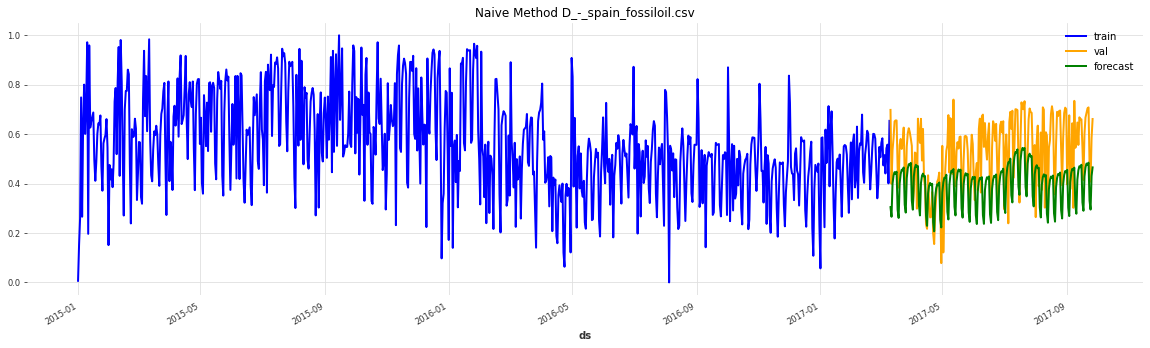

In [19]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [20]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 800 :
        print("ERROR, len(df_fit_naive[{}] = ".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 200 :
        print("ERROR, len(df_true_prediction_naive[{}] = ".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----


In [21]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 800 :
        print("ERROR, len(df_fit_prophet[{}] = ".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 200 :
        print("ERROR, len(df_true_prediction_prophet[{}] = ".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
